In [1]:
from vbridge.data_loader.data import create_entityset
from vbridge.explainer.explanation import Explainer
from vbridge.featurization.feature import Featurization
from vbridge.modeling.model import ModelManager
from vbridge.task.task import pic_48h_in_admission_mortality_task

## 0. Load Task

We show to use the system with a predefined task called *pic_48h_in_admission_mortality*.

In the `Task` object, we define the 
* `task id` and `textual descriptions`,
* `dataset` used for the prediction tasks, 
* `target entity` where the label is derived from, 
* `feature entities` where the features are generated from,
* `labels`, defining the specific prediction tasks
* `selection variables`, used to select a group of patients sharing similar properties (e.g., age range)

This task aims to predict the patient's **mortality risk** (i.e., die or survive) during the hospital admission\
according to the patient's demographics, label tests, and vital signs in the **first 48 hours** after being admitted. 

In [2]:
# load the task
task = pic_48h_in_admission_mortality_task()
task

[desc]
id              : 48h in-admission mortality
short desc      : Prediction whether the patient will die or survive within this admission.
[feature]
target entity   : ADMISSIONS
feature entity  : PATIENTS, ADMISSIONS, LABEVENTS, CHARTEVENTS
[model]
labels          
- mortality     : ['low-risk', 'high-risk']

## 1. Load Entity Set

First, we load the tables from the [PIC dataset](http://pic.nbscn.org/) and organize them into an `Entityset`.\
In brief, an `Entityset` is a collection of dataframes and the relationships between them.

Please check [featuretools](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html) for more details.

In [3]:
# load the entity set
es = create_entityset('pic', verbose=False)

## 2. Generate Features

Then, we generate features from `feature entities` defined in the Task object.\
The generation process is automatically done by using the [Deep Feature Synthesis](https://featuretools.alteryx.com/en/stable/getting_started/afe.html) method. 

In [4]:
# load features
feat = Featurization(es, task)
fm, fl = feat.generate_features()

Built 5 features
Elapsed: 00:27 | Progress: 100%|██████████
Built 61 features
Elapsed: 03:45 | Progress: 100%|██████████
Built 50 features
Elapsed: 06:06 | Progress: 100%|██████████
Remove:  ['MEAN(CHARTEVENTS.VALUENUM)', 'STD(CHARTEVENTS.VALUENUM)', 'TREND(CHARTEVENTS.VALUENUM, CHARTTIME)', 'MEAN(LABEVENTS.VALUENUM)']


In [5]:
fm.head()

,ICD10_CODE_CN,PATIENTS.GENDER,MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1014),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1007),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1016),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1002),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1003),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1001),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1006),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1015),...,MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5224),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5252),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5218),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5115),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5094),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5493),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5114),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5237),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 6318),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5228)
HADM_ID,,,,,,,,,,,,,,,,,,,,,
103784,O60.000,F,NaN,0.0,NaN,NaN,161.0,37.00,NaN,NaN,...,22.0,92.8,105.0,96.266667,2.43,0.14,305.333333,7.3315,0.263333,0.35
109451,Q21.000,F,NaN,3.0,96.0,134.0,NaN,36.60,97.0,63.0,...,NaN,NaN,NaN,88.900000,1.91,0.02,319.000000,NaN,0.080000,NaN
109598,Q26.300,M,NaN,NaN,109.0,122.0,NaN,36.80,98.0,48.0,...,NaN,NaN,NaN,83.700000,5.74,0.01,332.000000,NaN,0.690000,NaN
109522,Q21.100,F,NaN,NaN,101.0,114.0,NaN,36.10,98.0,70.0,...,NaN,NaN,NaN,82.800000,1.97,0.05,328.000000,NaN,0.140000,NaN
109477,Q93.500,M,NaN,NaN,110.0,118.0,NaN,37.86,96.0,58.0,...,NaN,NaN,NaN,92.000000,6.65,0.03,316.000000,NaN,0.050000,NaN


## 3. Train Models

Third, we train a sample machine learning model (i.e., xgboost) for the mortality prediction task and evaluate the model performance. 

In [6]:
# train an xgboost model to predict the mortality risk
model_manager = ModelManager(fm, es, task)
model_manager.fit_all()

# evaluate the model
model_manager.evaluate()

[17:24:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,AUROC,Accuracy,Confusion Matrix,F1 Macro,Precision,Recall
mortality,0.842399,0.96994,"[[484, 4], [11, 0]]",0.49237,0.488889,0.495902


## 4. Generate Explanations

At last, we explain the model predictions.\
In specific, we provide three types of explanations in different layers of depth.
* **Feature contributions**. We use [SHAP](https://github.com/slundberg/shap) to calculate each feature's contributions to the prediction.
* **What-if analysis**. In medical prediction problems, clinicians and biomedical researchers focus more on the **abnormal values** (i.e., out of the 95% confidence interval). Results from the what-if-analysis show the model prediction and the feature contribution after changing a patient's one abnormal feature value to the normal level.
* **Influential records**. For features with abnormal values, we calculate the influence of the raw health records (to the feature values) and summarize influential periods.

In this example, we only show the first type of explanations. Check our [paper](https://arxiv.org/abs/2108.02550) for more details. 

In [7]:
# generate shap values
shap_values = model_manager.explain(X=fm, target='mortality')
shap_values.head()

,ICD10_CODE_CN,PATIENTS.GENDER,MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1014),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1007),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1016),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1002),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1003),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1001),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1006),MEAN(CHARTEVENTS.VALUENUM WHERE ITEMID = 1015),...,MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5224),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5252),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5218),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5115),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5094),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5493),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5114),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5237),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 6318),MEAN(LABEVENTS.VALUENUM WHERE ITEMID = 5228)
0,-0.011759,0.0,-0.004123,0.0,-0.005860,0.033211,0.685555,-0.081054,0.133605,-0.081626,...,0.0,0.031259,-0.014576,-0.018078,-0.104538,0.246305,-0.453915,0.046803,-0.034464,0.075477
1,-0.312225,0.0,-0.002878,0.0,-0.074561,-0.295856,-0.118467,-0.121558,-0.888711,-0.139179,...,0.0,-0.044529,-0.127210,0.059298,-0.278904,-0.274302,0.013916,-0.037072,-0.010443,-0.141038
2,-0.020264,0.0,-0.003896,0.0,0.054537,0.137603,-0.201192,-0.043776,-0.960779,-0.022811,...,0.0,-0.002822,-0.071775,0.062990,0.326180,-0.343035,-0.011315,-0.037072,-0.035350,-0.155788
3,-0.017378,0.0,-0.006851,0.0,0.019202,0.159078,-0.238284,-0.296521,-0.908007,-0.257068,...,0.0,-0.004287,-0.062588,-0.088628,-0.283225,-0.182043,-0.048179,-0.037072,-0.010443,-0.144077
4,-0.004345,0.0,-0.003896,0.0,0.112969,0.137603,-0.202626,-0.113631,-0.006227,-0.167819,...,0.0,-0.001284,-0.099436,0.308591,-0.002834,-0.397783,-0.090690,-0.037072,-0.012242,-0.155788


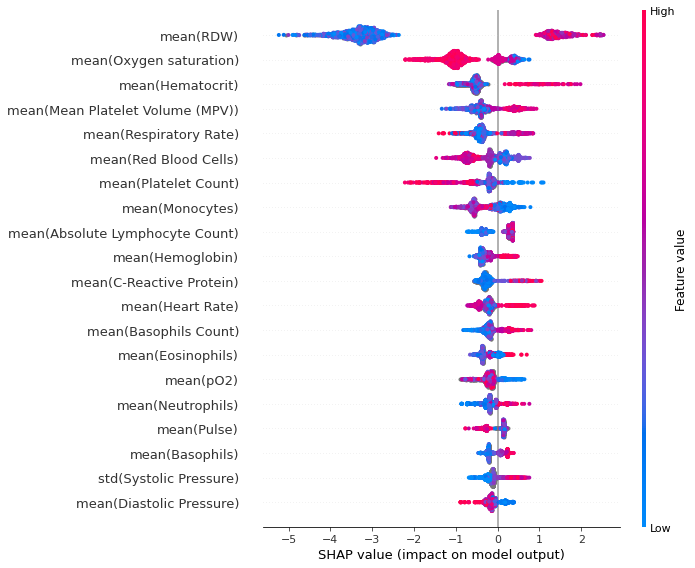

In [8]:
import shap

from vbridge.utils.entityset_helpers import get_item_dict
from vbridge.utils.feature_helpers import get_feature_description

# rename the feature names to interpretable ones
item_dict = get_item_dict(es)
feature_names = [get_feature_description(feature, item_dict)['desc'] for feature in fl]

# visualize the shap values of the most important features
shap.summary_plot(shap_values.values, fm.values, feature_names=feature_names)